# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

# Przygotowanie odpowiednich danych

In [2]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../../data/DogsCats'
Folder docelowy:
 * '../../data/Photos'
Folder Casia:
 * '../../data/Casia'
'''

dir_path = '../../data/sCasia'
A_folder = 'originals'
B_folder = 'photoshops'

# Załadowanie danych

In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [4]:
# Wilkości odpowiednie dla ResNetu

IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,1
1,../../data/sCasia/originals/Au_ani_00016.jpg,1
2,../../data/sCasia/originals/Au_ani_00031.jpg,1
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,0
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,0


In [8]:
df.shape

(200, 2)

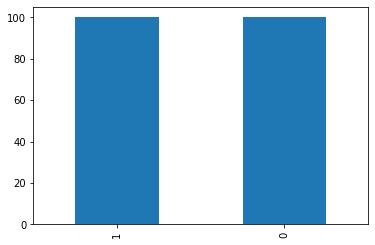

In [9]:
df['category'].value_counts().plot.bar()

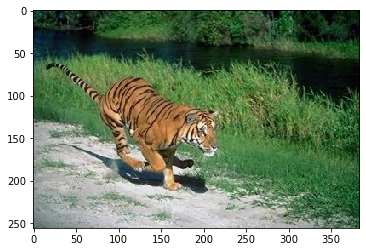

In [10]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# ELA

In [11]:
import cv2
from PIL import Image, ImageChops, ImageEnhance

def ft_ela(image_path):
    im = Image.open(image_path).convert('RGB')
    im.save('tmp.jpg', 'JPEG', quality=95)
    resaved_im = Image.open('tmp.jpg')

    ela_im = ImageChops.difference(im, resaved_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    ela_im = ela_im.resize(IMAGE_SIZE)
    ret = numpy.array(ela_im).flatten() / 255

    return ret, ela_im

Kształt: (67500,)
Max: 1.0
Min: 0.0


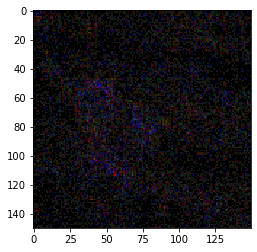

In [12]:
ela = ft_ela(sample)

plt.imshow(ela[1])
print(f'Kształt: {ela[0].shape}')
print(f'Max: {numpy.amax(ela[0])}')
print(f'Min: {numpy.amin(ela[0])}')

# Przeliczenie Cech Zdjęć + Kategorii

In [13]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X = []
Y = []

for index, row in df.iterrows():
    X.append(numpy.array(ft_ela(row[0])[0]))
    Y.append(row[1])

In [14]:
df.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,1
1,../../data/sCasia/originals/Au_ani_00016.jpg,1
2,../../data/sCasia/originals/Au_ani_00031.jpg,1
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,0
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,0


In [15]:
X = numpy.array(X)
Y = numpy.array(Y)

In [16]:
X.shape

(200, 67500)

In [17]:
Y.shape

(200,)

# Zapis/Odczyt

In [18]:
import h5py

def save(features, labels, dataframe, name):
    h5f_data = h5py.File('data_' + str(name) + '.h5', 'w')
    h5f_data.create_dataset('dataset', data=numpy.array(features))

    h5f_label = h5py.File('labels_' + str(name) + '.h5', 'w')
    h5f_label.create_dataset('dataset', data=numpy.array(labels))

    h5f_data.close()
    h5f_label.close()

    dataframe.to_csv('dataframe_' + str(name) + '.csv')
    
def load(features, labels, dataframe):
    h5f_data  = h5py.File(features, 'r')
    h5f_label = h5py.File(labels, 'r')

    global_features_string = h5f_data['dataset']
    global_labels_string   = h5f_label['dataset']

    global_features = numpy.array(global_features_string)
    global_labels   = numpy.array(global_labels_string)

    h5f_data.close()
    h5f_label.close()
    
    df = pd.read_csv(dataframe, index_col = 0)  
    
    return global_features, global_labels, df
    
save(X, Y, df, name='Casia_CNN')

X, Y, df = load('data_Casia_CNN.h5', 'labels_Casia_CNN.h5', 'dataframe_Casia_CNN.csv')

In [19]:
df.head()

,filename,category
0,../../data/sCasia/originals/Au_ani_00096.jpg,1
1,../../data/sCasia/originals/Au_ani_00016.jpg,1
2,../../data/sCasia/originals/Au_ani_00031.jpg,1
3,../../data/sCasia/photoshops/Tp_D_CNN_S_N_sec0...,0
4,../../data/sCasia/photoshops/Tp_D_CNN_M_N_sec1...,0


In [20]:
print('Kształt po wczytaniu:')
print(f'\t X: {X.shape}')
print(f'\t Y: {Y.shape}')

Kształt po wczytaniu:
	 X: (200, 67500)
	 Y: (200,)


# Funkcję liczące statystyki

In [21]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model, clone_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from keras.optimizers import RMSprop

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='binary')
    recall = recall_score(_y_true, _y_pred, average='binary')
    fscore = f1_score(_y_true, _y_pred, average='binary')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    fig = plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes,
                          figsize=(10, 8))
    
    return fig

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=0)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=0)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=0)

# Dobór parametrów

In [27]:
# To Do

epochs = 50
batch_size = 100
activation = 'relu'
loss_type = 'binary_crossentropy'
optimizer = RMSprop(lr=1e-5)
dropout = 0.25

# Model

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications import VGG16

# Model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(512, activation=activation))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________


In [30]:
model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

In [31]:
model.save("base_model.h5")

# Fit

In [32]:
from tabulate import tabulate

features = X
labels = Y
name = 'CNN'


tcm_list = []
tAccuracy_list = []
tPrecision_list = []
tRecall_list = []
tFScore_list = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=odp)
    
scores_a = numpy.zeros((1, 5))
scores_p = numpy.zeros((1, 5))
scores_r = numpy.zeros((1, 5))
scores_f = numpy.zeros((1, 5))

for fold_id, (train_index, test_index) in enumerate(kf.split(features, labels)):
    X_train = features[train_index].reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
    Y_train = labels[train_index]
    
    X_test = features[test_index].reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
    Y_test = labels[test_index]
    
    EARLY_STOP_PATIENCE = 10
    LEARNING_RATE_PATIENCE = 5

    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=0)
    cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=0)
    cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=0)
    
    clf = load_model('base_model.h5', custom_objects={'get_f1': get_f1})
    history = clf.fit(
        x = X_train,
        y = Y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, Y_test),
        callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction],
        verbose = 0
    )
    
    clf.load_weights('best.h5')
    y_pred = clf.predict(X_test)
    y_pred = y_pred.reshape(-1)
    y_pred = numpy.where(y_pred > 0.5, 1, 0)

    accuracy, precision, recall, fscore = countStats(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred)
    scores_a[0, fold_id] = accuracy
    scores_p[0, fold_id] = precision
    scores_r[0, fold_id] = recall
    scores_f[0, fold_id] = fscore

    tAccuracy_list.append(accuracy)
    tPrecision_list.append(precision)
    tRecall_list.append(recall)
    tFScore_list.append(fscore)
    tcm_list.append(cm)
    
    print(f'[{fold_id + 1} done!]', end='')

printmd(f'# {name}:')
print(f'\n\nKształt danych:')
print(f'\t X_train: {X_train.shape}')
print(f'\t X_test: {X_test.shape}')
print(f'\t y_train: {Y_train.shape}')
print(f'\t y_test: {Y_test.shape}')
    
accuracy_m = numpy.mean(tAccuracy_list)
precision_m = numpy.mean(tPrecision_list)
recall_m = numpy.mean(tRecall_list)
fscore_m = numpy.mean(tFScore_list)
        
accuracy_std = numpy.std(tAccuracy_list)
precision_std = numpy.std(tPrecision_list)
recall_std = numpy.std(tRecall_list)
fscore_std = numpy.std(tFScore_list)
    
cm = sum(tcm_list)

results = [['CNN', 
            f'{accuracy_m:.3f} ({accuracy_std:.2f})',
            f'{precision_m:.3f} ({precision_std:.2f})',
            f'{recall_m:.3f} ({recall_std:.2f})',
            f'{fscore_m:.3f} ({fscore_std:.2f})',
            f'{cm}']]
                            
printmd(f'### Rezultaty:')
headers = ["Kernel", "Accuracy", "Precision", "Recall", "Fscore", "CM"]
print('\n')
print(tabulate(results, headers=headers))
                            
with open(f'{name}_result.txt', 'w') as f:
    print(tabulate(results, headers=headers), file=f)
                            
numpy.save(f'{name}_results_a', scores_a)
numpy.save(f'{name}_results_p', scores_p)
numpy.save(f'{name}_results_r', scores_r)
numpy.save(f'{name}_results_f', scores_f)

[1 done!][2 done!][3 done!][4 done!][5 done!]

# CNN:



Kształt danych:
	 X_train: (160, 150, 150, 3)
	 X_test: (40, 150, 150, 3)
	 y_train: (160,)
	 y_test: (40,)


### Rezultaty:



Kernel    Accuracy      Precision     Recall        Fscore        CM
--------  ------------  ------------  ------------  ------------  ---------
CNN       0.875 (0.02)  0.896 (0.03)  0.850 (0.03)  0.872 (0.02)  [[90 10]
                                                                   [15 85]]


In [33]:
# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis
model.save('the_best.h5')

# Zapis History
numpy.save('history.npy', history.history)
# history = numpy.load('history.npy', allow_pickle='TRUE').item()

# Statystyki

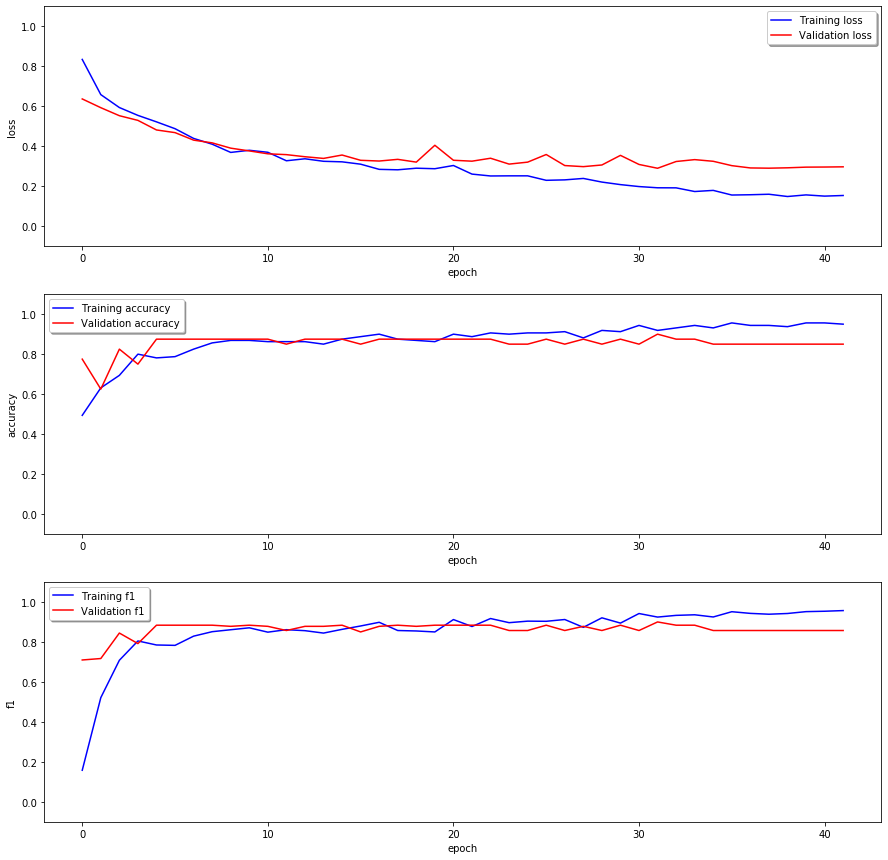

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Wykres loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_ylim([-0.1, 1.1])
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_ylim([-0.1, 1.1])
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_ylim([-0.1, 1.1])
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


# plt.tight_layout()
plt.show()
fig.savefig('history.png')

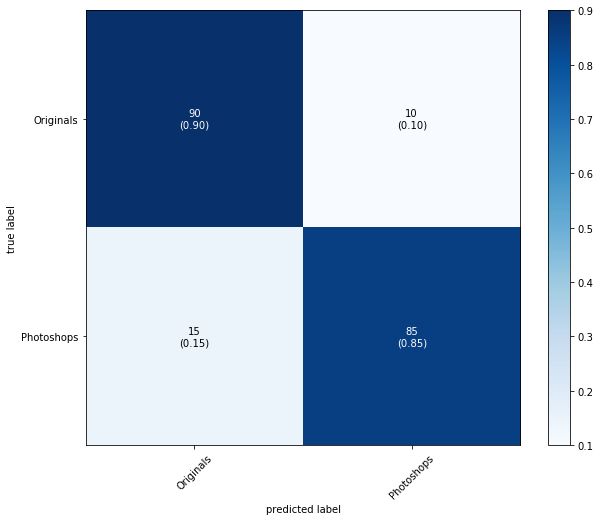

In [35]:
fig = plot_cm(cm, ['Originals', 'Photoshops'])
fig[0].savefig('cm.png')